In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import requests
from pathlib import Path
import yfinance as yf
import pandas_datareader.data as web 

In [ ]:
import sys, subprocess, pkgutil
print("Kernel:", sys.executable)  

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pandas_datareader"])

In [2]:
startTime = 1502928000000      
endTime   = 4102444800000      
limit     = 1000

chunks = []
while startTime < endTime:
    url = ("https://api.binance.com/api/v3/klines"
           f"?symbol=BTCUSDT&interval=1d&limit={limit}&startTime={startTime}")
    data = requests.get(url, timeout=30).json()
    if not data:
        break

    df = pd.DataFrame(data, columns=[
        "Open time","Open","High","Low","Close","Volume",
        "Close time","Quote asset volume","Number of trades",
        "Taker buy base asset volume","Taker buy quote asset volume","Ignore"
    ])

    df["Date"] = pd.to_datetime(df["Open time"], unit="ms")

    df = df[["Date","Open","High","Low","Close","Volume"]]

    num_cols = ["Open","High","Low","Close","Volume"]
    df[num_cols] = df[num_cols].astype(float)

    chunks.append(df)

    # esto es lo que mejora lo que habia hecho el mija
    startTime = data[-1][6] + 1


btc = (pd.concat(chunks, ignore_index=True)
         .drop_duplicates(subset="Date")
         .sort_values("Date")
         .set_index("Date"))

btc.to_csv("btc_usdt_binance_daily.csv")
btc.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-09-13,116029.41,116298.78,115127.27,115918.29,8269.40394
2025-09-14,115918.29,116165.19,115135.00,115268.01,6707.60197
2025-09-15,115268.01,116757.99,114384.00,115349.71,13212.51149
2025-09-16,115349.71,116964.27,114737.11,116788.96,10926.90940
2025-09-17,116788.96,117286.73,114720.81,115786.17,14713.31128


In [3]:
btc.sample(n=100, random_state=42)


,Open,High,Low,Close,Volume
Date,,,,,
2025-02-21,98305.01,99475.00,94871.95,96181.98,32249.281400
2021-01-23,32950.00,33456.00,31390.16,32078.00,64595.287675
2018-02-07,7655.02,8476.00,7150.01,7599.00,60778.460497
2025-05-31,103985.47,104900.00,103068.55,104591.88,11289.359220
2019-12-22,7131.59,7518.54,7122.47,7501.44,39137.455150
...,...,...,...,...,...
2023-08-29,26120.00,28142.85,25922.00,27716.34,74251.994880
2018-11-23,4370.90,4484.00,4222.94,4420.61,49371.920322
2018-10-27,6538.63,6558.35,6463.04,6505.60,7776.907864


,Open,High,Low,Close,Volume
Date,,,,,
2025-09-10,111546.38,114313.13,110917.45,113960.00,17517.41823
2025-09-11,113960.00,115488.09,113430.00,115482.69,13676.73119
2025-09-12,115482.69,116665.63,114740.99,116029.42,15324.10719
2025-09-13,116029.41,116298.78,115127.27,115918.29,8269.40394
2025-09-14,115918.29,116165.19,115141.80,115900.00,5770.71867


,Open,High,Low,Close,Volume
count,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000
mean,33479.393436,34217.577350,32694.770840,33517.273484,64044.167776
std,29921.723519,30432.424544,29401.415691,29955.325700,77790.834801
min,3188.010000,3276.500000,2817.000000,3189.020000,228.108068
25%,8914.180000,9197.610000,8700.000000,8915.330000,25534.284240
50%,23629.760000,24226.000000,23106.770000,23643.510000,40872.229909
75%,49142.955000,50517.845000,47500.000000,49188.705000,67867.650774
max,123306.440000,124474.000000,118920.920000,123306.430000,760705.362783


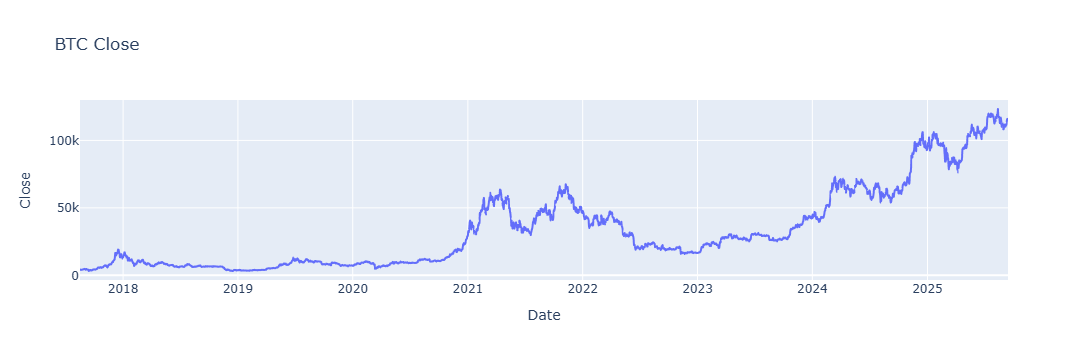

In [16]:
btc = pd.read_csv("btc_usdt_binance_daily.csv", parse_dates=["Date"], index_col="Date")
btc = btc[~btc.index.duplicated(keep="first")].asfreq("D").ffill()

display(btc.tail(), btc.describe())

fig = px.line(btc, x=btc.index, y="Close", title="BTC Close")
fig.show()


In [8]:
btc.shape



(2951, 5)

In [9]:
n_raw = btc.shape[0]

n_clean = btc.shape[0]

print(f"Registros originales: {n_raw}")
print(f"Registros después de limpieza: {n_clean}")
print(f"Diferencia: {n_raw - n_clean}")

if n_raw-n_clean == 0:
    print("Todos los registros del dataframe son distintos")


Registros originales: 2951
Registros después de limpieza: 2951
Diferencia: 0
Todos los registros del dataframe son distintos


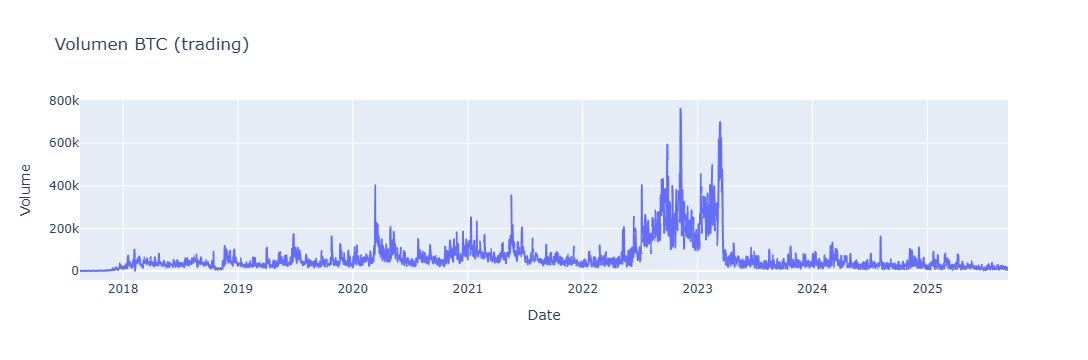

In [17]:
# Volumen
fig = px.line(btc, x=btc.index, y="Volume", title="Volumen BTC (trading)")
fig.show()


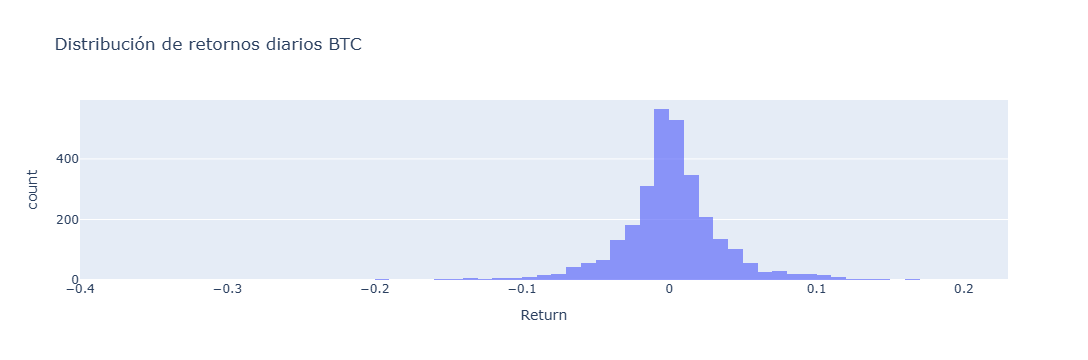

In [22]:
btc["Return"] = btc["Close"].pct_change()
fig = px.histogram(
    btc.dropna(),      
    x="Return", 
    nbins=100, 
    opacity=0.7, 
    title="Distribución de retornos diarios BTC"
)
fig.show()


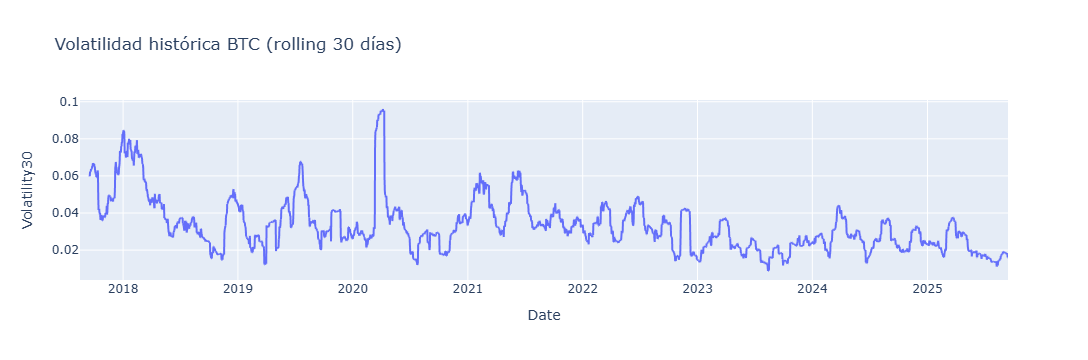

In [23]:

btc["Volatility30"] = btc["Return"].rolling(window=30).std()

fig = px.line(
    btc, 
    x=btc.index, 
    y="Volatility30", 
    title="Volatilidad histórica BTC (rolling 30 días)"
)
fig.show()


In [27]:
btc["MA7"]  = btc["Close"].rolling(window=7).mean()   
btc["MA30"] = btc["Close"].rolling(window=30).mean()  

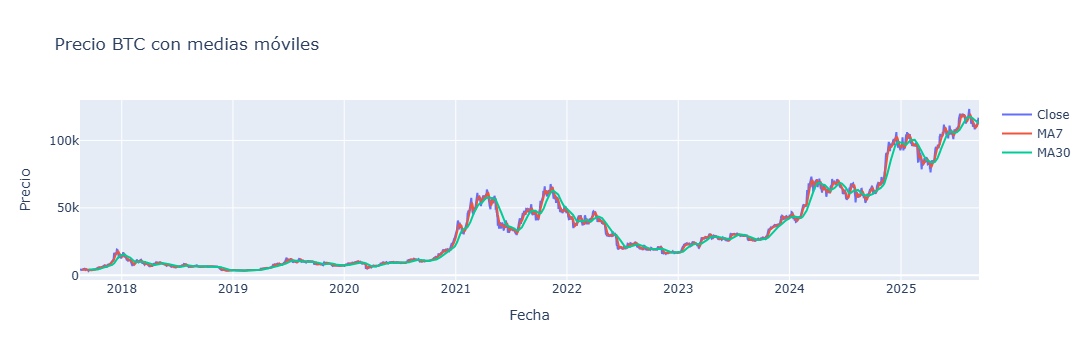

In [29]:
import plotly.graph_objects as go

fig = go.Figure()
for col in ["Close", "MA7", "MA30"]:
    fig.add_trace(go.Scatter(x=btc.index, y=btc[col], mode="lines", name=col))
fig.update_layout(title="Precio BTC con medias móviles", xaxis_title="Fecha", yaxis_title="Precio")
fig.show()


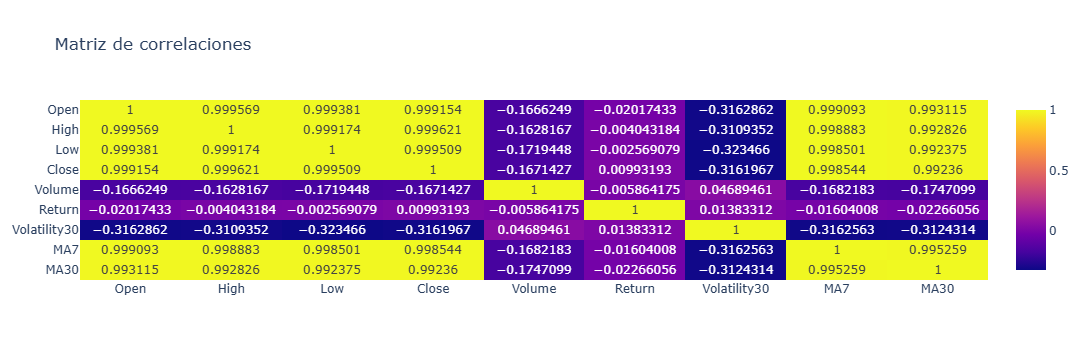

In [30]:
fig = px.imshow(
    btc.corr(),
    text_auto=True,
    aspect="auto",
    title="Matriz de correlaciones"
)
fig.show()

In [4]:
min_close = btc["Close"].min()
max_close = btc["Close"].max()
mean_close = btc["Close"].mean()
closest_to_mean = btc.loc[(btc["Close"] - mean_close).abs().idxmin(), "Close"]

print(f"Valor más bajo (Close): {min_close}")
print(f"Valor más alto (Close): {max_close}")
print(f"Valor más cercano a la media (Close): {closest_to_mean}")

Valor más bajo (Close): 3189.02
Valor más alto (Close): 123306.43
Valor más cercano a la media (Close): 33634.09


In [15]:


startTime = 1502928000000      
endTime   = 4102444800000      
limit     = 1000

csv_dir = Path.cwd() / "CSVs-2"
chunks = []
while startTime < endTime:
    url = ("https://api.binance.com/api/v3/klines"
           f"?symbol=ETHUSDT&interval=1d&limit={limit}&startTime={startTime}")
    data = requests.get(url, timeout=30).json()
    if not data:
        break

    df = pd.DataFrame(data, columns=[
        "Open time","Open","High","Low","Close","Volume",
        "Close time","Quote asset volume","Number of trades",
        "Taker buy base asset volume","Taker buy quote asset volume","Ignore"
    ])

    df["Date"] = pd.to_datetime(df["Open time"], unit="ms")
    df = df[["Date","Open","High","Low","Close","Volume"]]

    # Convertir columnas numéricas
    num_cols = ["Open","High","Low","Close","Volume"]
    df[num_cols] = df[num_cols].astype(float)

    chunks.append(df)

 
    startTime = data[-1][6] + 1  

eth = (pd.concat(chunks, ignore_index=True)
         .drop_duplicates(subset="Date")
         .sort_values("Date")
         .set_index("Date"))


eth.to_csv(csv_dir / "eth_usdt_binance_daily.csv")

eth.head(), eth.tail()


(              Open    High     Low   Close      Volume
 Date                                                  
 2017-08-17  301.13  312.18  298.00  302.00  7030.71034
 2017-08-18  302.00  311.79  283.94  293.96  9537.84646
 2017-08-19  293.31  299.90  278.00  290.91  2146.19773
 2017-08-20  289.41  300.53  282.85  299.10  2510.13871
 2017-08-21  299.10  346.52  294.60  323.29  5219.44542,
                Open     High      Low    Close       Volume
 Date                                                       
 2025-09-13  4712.16  4769.36  4605.00  4666.53  394393.6869
 2025-09-14  4666.54  4692.36  4576.89  4604.49  278244.3205
 2025-09-15  4604.48  4670.28  4466.00  4523.74  412291.9687
 2025-09-16  4523.74  4538.25  4424.00  4501.29  293307.1099
 2025-09-17  4501.30  4557.67  4412.00  4516.88  417167.3007)

In [16]:
min_close = eth["Close"].min()
max_close = eth["Close"].max()
mean_close = eth["Close"].mean()
closest_to_mean = eth.loc[(eth["Close"] - mean_close).abs().idxmin(), "Close"]

print(f"Valor más bajo (Close): {min_close}")
print(f"Valor más alto (Close): {max_close}")
print(f"Valor más cercano a la media (Close): {closest_to_mean}")

Valor más bajo (Close): 83.76
Valor más alto (Close): 4832.07
Valor más cercano a la media (Close): 1578.48


Leyendo BTC desde: c:\ML_Bitcoin\EDA-2\CSVs-2\btc_usdt_binance_daily.csv
Leyendo ETH desde: c:\ML_Bitcoin\EDA-2\CSVs-2\eth_usdt_binance_daily.csv


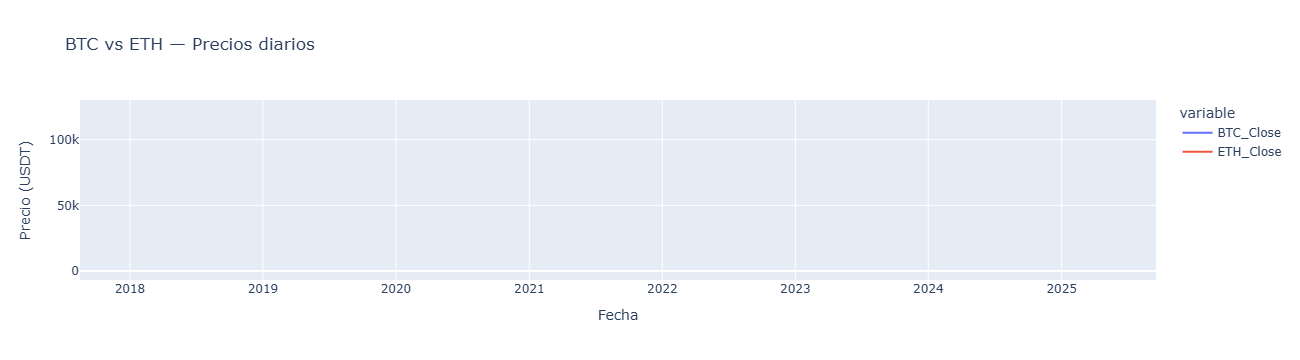

Correlación de retornos diarios BTC–ETH: 0.777


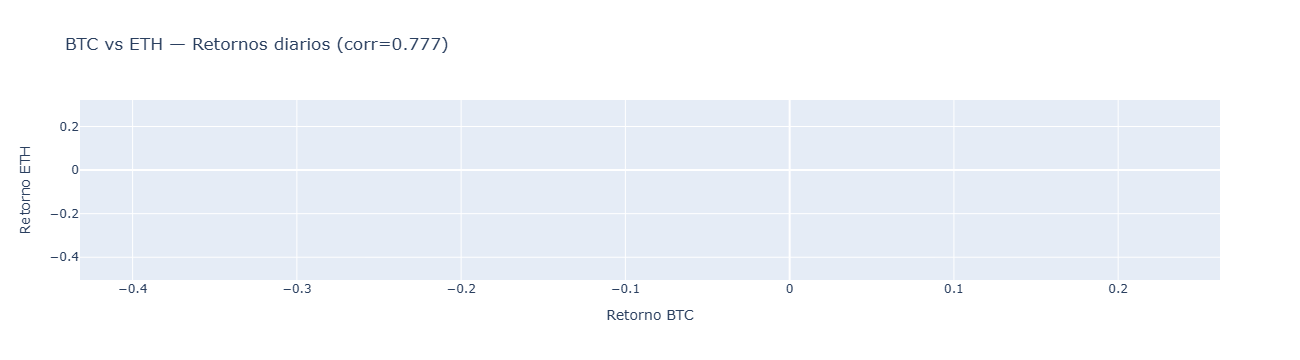

In [6]:
csv_dir = Path.cwd() / "CSVs-2"
btc_path = csv_dir / "btc_usdt_binance_daily.csv"
eth_path = csv_dir / "eth_usdt_binance_daily.csv"

print("Leyendo BTC desde:", btc_path)
print("Leyendo ETH desde:", eth_path)

btc = pd.read_csv(btc_path, parse_dates=[0], index_col=0)
eth = pd.read_csv(eth_path, parse_dates=[0], index_col=0)

pair = pd.DataFrame({
    "BTC_Close": btc["Close"],
    "ETH_Close": eth["Close"],
}).dropna()

fig = px.line(
    pair.reset_index(),
    x="Date",
    y=["BTC_Close", "ETH_Close"],
    title="BTC vs ETH — Precios diarios"
)
fig.update_layout(xaxis_title="Fecha", yaxis_title="Precio (USDT)")
fig.show()

rets = pair.pct_change().dropna()
corr = rets.corr().loc["BTC_Close", "ETH_Close"]
print(f"Correlación de retornos diarios BTC–ETH: {corr:.3f}")

fig2 = px.scatter(
    rets, x="BTC_Close", y="ETH_Close",
    trendline="ols",
    title=f"BTC vs ETH — Retornos diarios (corr={corr:.3f})"
)
fig2.update_layout(xaxis_title="Retorno BTC", yaxis_title="Retorno ETH")
fig2.show()

# === 7) Guardar dataset combinado ===
pair.to_csv(csv_dir / "btc_eth_close_aligned.csv")


Bonos descargados desde FRED.
Dataset guardado en: c:\ML_Bitcoin\EDA-2\CSVs-2\btc_eth_treasuries.csv


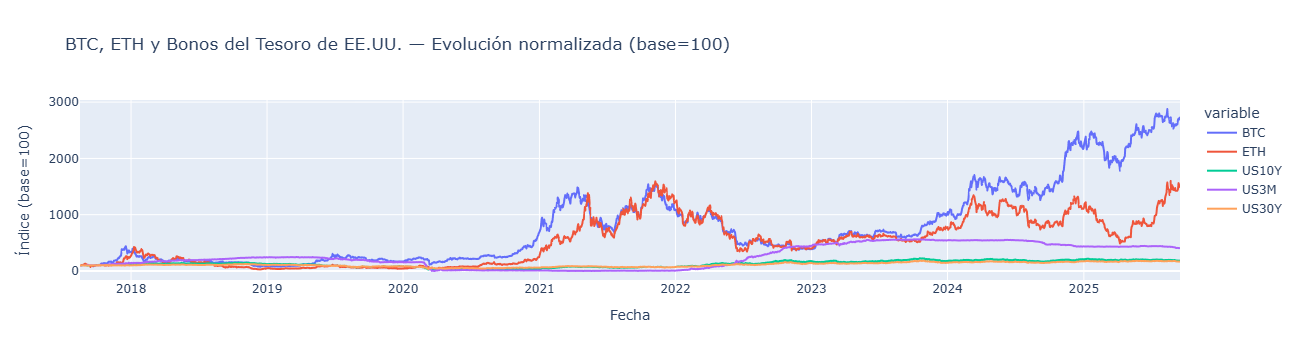

In [8]:

# Definir carpeta donde están los CSVs de BTC y ETH, y cargar sus datos
csv_dir = Path.cwd() / "CSVs-2"
btc = pd.read_csv(csv_dir / "btc_usdt_binance_daily.csv", parse_dates=[0], index_col="Date")
eth = pd.read_csv(csv_dir / "eth_usdt_binance_daily.csv", parse_dates=[0], index_col="Date")

# Tomamos el rango de fechas común entre BTC y ETH para usarlo con los bonos
start, end = btc.index.min(), btc.index.max()

# Descargar los rendimientos de los Bonos del Tesoro de EE.UU. desde FRED
# (DGS10 = 10 años, DGS3MO = 3 meses, DGS30 = 30 años)
# Si FRED falla, usa ETFs equivalentes desde Yahoo Finance como proxies.
treasuries = None
try:
    t10 = web.DataReader("DGS10", "fred", start, end)   # 10-Year
    t3m = web.DataReader("DGS3MO", "fred", start, end)  # 3-Month
    t30 = web.DataReader("DGS30", "fred", start, end)   # 30-Year
    treasuries = pd.concat([t10, t3m, t30], axis=1).dropna()
    treasuries.columns = ["US10Y", "US3M", "US30Y"]
    print("Bonos descargados desde FRED.")
except Exception as e:
    print("No se pudo usar FRED:", e)
    try:
        data = yf.download(["TLT","IEF","SHY"], start=start.strftime("%Y-%m-%d"),
                           end=end.strftime("%Y-%m-%d"), progress=False, threads=False, auto_adjust=False)
        if isinstance(data.columns, pd.MultiIndex):
            data = data["Close"]
        treasuries = data.rename(columns={"TLT":"US30Y_proxy","IEF":"US10Y_proxy","SHY":"US3M_proxy"}).dropna()
        print("Bonos proxy descargados desde Yahoo (ETFs TLT/IEF/SHY).")
    except Exception as e2:
        print("También falló Yahoo:", e2)
        treasuries = pd.DataFrame()
# Unir en un mismo DataFrame:
# - Precio de cierre de BTC
# - Precio de cierre de ETH
# - Rendimientos de los bonos (FRED o proxies de ETFs)
assets = pd.DataFrame({
    "BTC": btc["Close"],
    "ETH": eth["Close"],
}).join(treasuries, how="inner")

# Guardar dataset combinado en CSV
out_path = csv_dir / "btc_eth_treasuries.csv"
assets.to_csv(out_path)
print("Dataset guardado en:", out_path)

# Normalizar todos los valores a base 100 para compararlos en la misma escala
# (ejemplo: todos arrancan en 100 el primer día)
normalized = assets / assets.iloc[0] * 100
normalized_plot = normalized.reset_index().rename(columns={"index": "Date"})

# Graficar la evolución relativa de BTC, ETH y los bonos (todos base=100)
fig = px.line(
    normalized_plot,
    x="Date",
    y=normalized.columns,
    title="BTC, ETH y Bonos del Tesoro de EE.UU. — Evolución normalizada (base=100)"
)
fig.update_layout(xaxis_title="Fecha", yaxis_title="Índice (base=100)")
fig.show()




In [ ]:
# FRED significa Federal Reserve Economic Data, y es una enorme base de datos económica mantenida por el Banco de la Reserva Federal de St. Louis (Estados Unidos).
# Nos hemos inclinado por usar FRED porque es una fuente confiable y ampliamente utilizada para datos económicos, incluyendo tasas de interés de bonos del gobierno, indicadores macroeconómicos, y otros datos financieros relevantes.
# Además de que yahoo finance no contenia la información o no la servia.

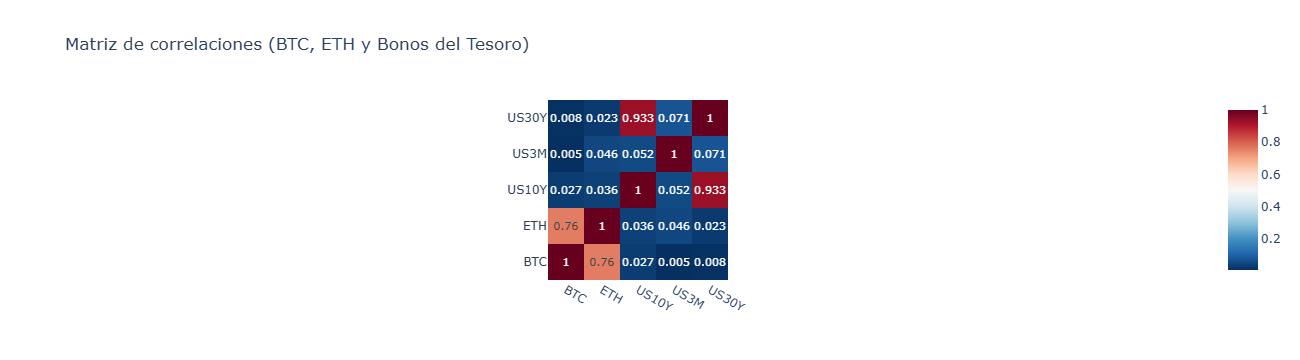

In [10]:
corr = rets.corr().round(3)  # redondeo a 3 decimales
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    origin="lower",
    title="Matriz de correlaciones (BTC, ETH y Bonos del Tesoro)"
)
fig.show()

In [ ]:
#BTC y ETH muestran alta correlación entre sí (~0.76), pero casi nula con los bonos del Tesoro, lo que confirma que las criptos se comportan como un mercado independiente. 
# En cambio, los bonos de largo plazo (10Y y 30Y) están fuertemente correlacionados (~0.93), reflejando su dependencia común de la política monetaria.

DXY descargado correctamente desde FRED.
Dataset guardado en: c:\ML_Bitcoin\EDA-2\CSVs-2\btc_eth_dxy.csv


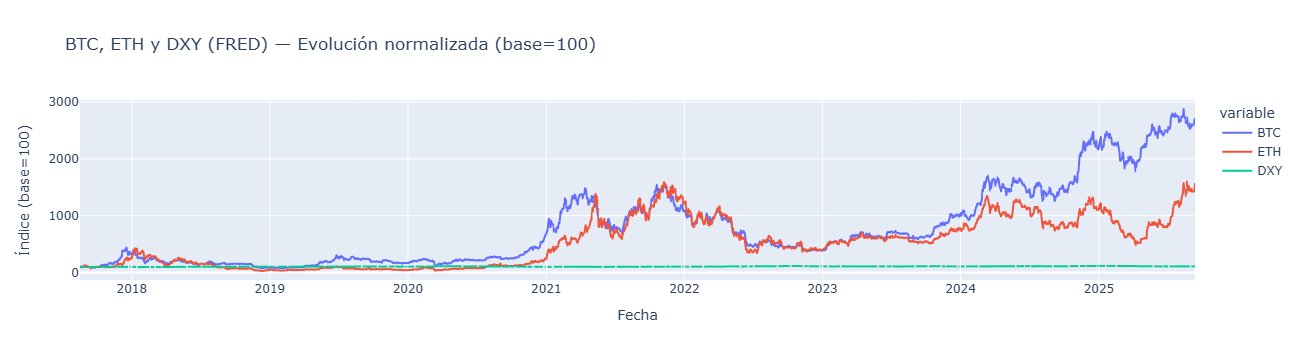

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21412\3050912765.py:43: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



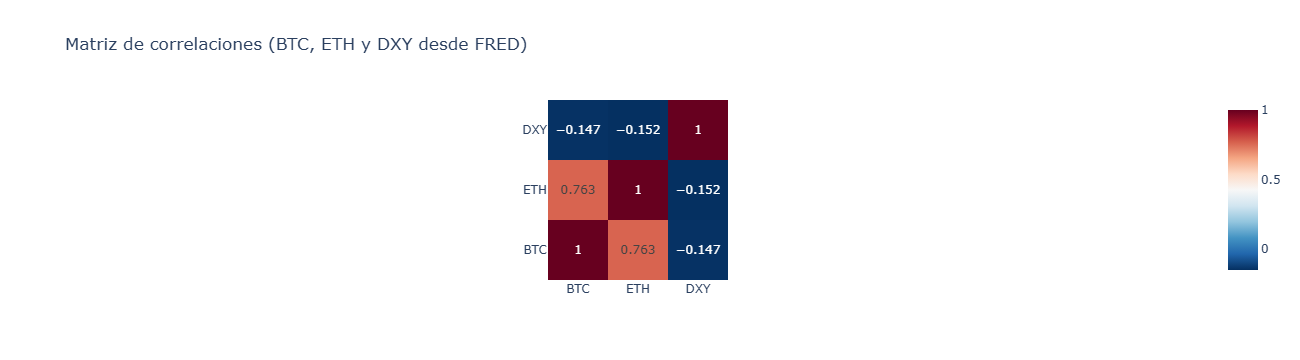

In [15]:
csv_dir = Path.cwd() / "CSVs-2"
btc = pd.read_csv(csv_dir / "btc_usdt_binance_daily.csv", parse_dates=["Date"], index_col="Date")
eth = pd.read_csv(csv_dir / "eth_usdt_binance_daily.csv", parse_dates=["Date"], index_col="Date")

start, end = btc.index.min(), btc.index.max()

try:
    dxy = web.DataReader("DTWEXBGS", "fred", start, end)
    dxy = dxy.rename(columns={"DTWEXBGS": "DXY"})
    print("DXY descargado correctamente desde FRED.")
except Exception as e:
    print("No se pudo descargar DXY desde FRED:", e)
    dxy = pd.DataFrame()

# === Combinar BTC, ETH y DXY ===
assets_dxy = pd.DataFrame({
    "BTC": btc["Close"],
    "ETH": eth["Close"],
}).join(dxy, how="inner")

out_path = csv_dir / "btc_eth_dxy.csv"
assets_dxy.to_csv(out_path)
print("Dataset guardado en:", out_path)

# === Normalización base=100 ===
if not assets_dxy.empty:
    normalized_dxy = assets_dxy / assets_dxy.iloc[0] * 100

    # Aseguramos que el índice se llame "Date" al resetear
    normalized_dxy = normalized_dxy.reset_index().rename(columns={"index": "Date"})

    # === Gráfico evolución ===
    fig = px.line(
        normalized_dxy,
        x="Date",
        y=["BTC", "ETH", "DXY"],
        title="BTC, ETH y DXY (FRED) — Evolución normalizada (base=100)"
    )
    fig.update_layout(xaxis_title="Fecha", yaxis_title="Índice (base=100)")
    fig.show()

    # === Matriz de correlaciones ===
    rets_dxy = assets_dxy.pct_change().dropna()
    corr_dxy = rets_dxy.corr().round(3)

    fig_corr = px.imshow(
        corr_dxy,
        text_auto=True,
        color_continuous_scale="RdBu_r",
        origin="lower",
        title="Matriz de correlaciones (BTC, ETH y DXY desde FRED)"
    )
    fig_corr.show()
else:
    print("No se pudo obtener DXY, dataset vacío.")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21412\3599218128.py:2: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



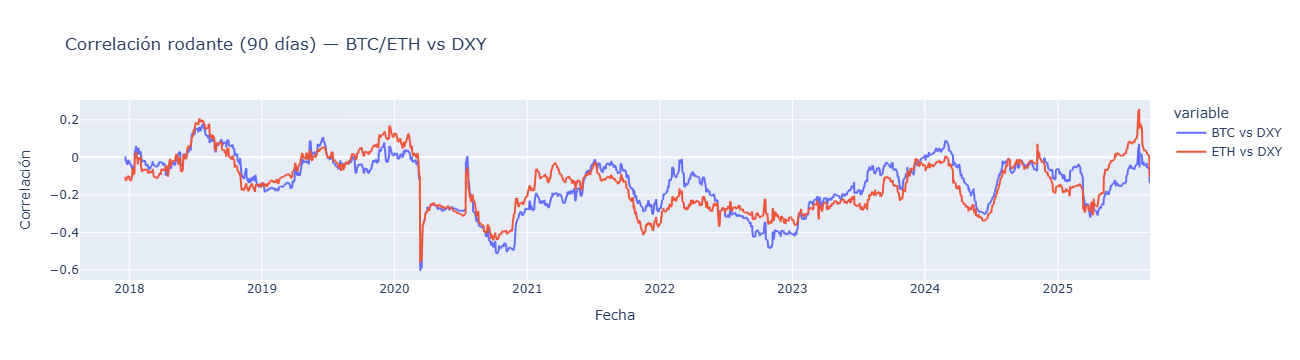

In [18]:

# calculamos retornos diarios
rets_dxy = assets_dxy.pct_change().dropna()

# correlación rodante (90 días)
rolling_corr_btc = rets_dxy["BTC"].rolling(window=90).corr(rets_dxy["DXY"])
rolling_corr_eth = rets_dxy["ETH"].rolling(window=90).corr(rets_dxy["DXY"])

# unimos en un dataframe
rolling_corr = pd.DataFrame({
    "BTC vs DXY": rolling_corr_btc,
    "ETH vs DXY": rolling_corr_eth
})


fig = px.line(
    rolling_corr.reset_index(),
    x="index",
    y=rolling_corr.columns,
    title="Correlación rodante (90 días) — BTC/ETH vs DXY"
)
fig.update_layout(xaxis_title="Fecha", yaxis_title="Correlación")
fig.show()

In [ ]:
# DXY es el índice del dólar estadounidense, que mide el valor del dólar en relación con una canasta de monedas extranjeras. 
# Nos interesa porque el valor del dólar puede influir en los precios de activos globales, incluyendo criptomonedas como BTC. 
# Por lo que si se refuerza el dólar, podría impactar negativamente en los precios de BTC, y viceversa.


In [5]:
import pandas as pd
from pathlib import Path


csv_dir = Path.cwd() / "CSVs-2"

# Cargar datasets principales
btc = pd.read_csv(csv_dir / "btc_usdt_binance_daily.csv", parse_dates=["Date"], index_col="Date")[["Close"]]
btc.rename(columns={"Close": "BTC_Close"}, inplace=True)

# Función para cargar y renombrar columna de cierre
def load_close(file_path, colname):
    df = pd.read_csv(file_path)

    # 1️⃣ Detectar columna de fecha (por nombre o posición)
    date_cols = [c for c in df.columns if str(c).lower() in ["date", "fecha", "time"]]
    if date_cols:
        df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], errors="coerce", dayfirst=True)
        df = df.set_index(date_cols[0])
    else:
        # Si no hay columna con nombre, usar la primera si parece fecha
        first_col = df.columns[0]
        try:
            df[first_col] = pd.to_datetime(df[first_col], errors="coerce")
            if df[first_col].notna().any():
                df = df.set_index(first_col)
            else:
                print(f"⚠️ No hay fechas válidas en {file_path.name}, se usa índice numérico.")
                df.index = pd.date_range(end=pd.Timestamp.today(), periods=len(df), freq="D")
        except:
            print(f"⚠️ {file_path.name}: sin columna de fecha, se genera índice diario.")
            df.index = pd.date_range(end=pd.Timestamp.today(), periods=len(df), freq="D")

    # 2️⃣ Buscar columna de cierre o equivalente
    close_candidates = [c for c in df.columns if "close" in c.lower() or "cierre" in c.lower()]
    if not close_candidates:
        close_candidates = [df.columns[-1]]  # usar última columna si no hay 'close'

    df = df[[close_candidates[0]]].rename(columns={close_candidates[0]: colname})

    # 3️⃣ Asegurar que el índice sea único y ordenado
    df = df[~df.index.duplicated()].sort_index()

    return df

drivers = pd.concat([
    btc,
    load_close(csv_dir / "eth_usdt_binance_daily.csv", "ETH_Close"),
    load_close(csv_dir / "SPX to 16.9.2025.csv", "SPX"),
    load_close(csv_dir / "WTI to 15.9.2025.csv", "WTI"),
    load_close(csv_dir / "Brent to 15.9.2025.csv", "BRENT"),
    load_close(csv_dir / "XAU-USD to 16.9.2025.csv", "GOLD"),
    load_close(csv_dir / "btc_eth_dxy.csv", "DXY"),
    load_close(csv_dir / "btc_eth_treasuries.csv", "US10Y")
], axis=1)

drivers = drivers.asfreq("D").ffill().dropna(how="all")
drivers.tail()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19440\3238010291.py:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], errors="coerce", dayfirst=True)


,BTC_Close,ETH_Close,SPX,WTI,BRENT,GOLD,DXY,US10Y
2025-09-13,115918.29,4666.53,"-0,05%","0,51%","0,93%","0,25%",120.4905,4.68
2025-09-14,115268.01,4604.49,"-0,05%","-0,02%","-0,13%","-0,13%",120.4905,4.68
2025-09-15,115349.71,4523.74,"0,47%","0,57%","0,91%","1,06%",120.4905,4.66
2025-09-16,116788.96,4501.29,"0,47%","0,57%","0,91%","0,48%",120.4905,4.65
2025-09-17,115786.17,4516.88,"0,47%","0,57%","0,91%","0,48%",120.4905,4.65


In [7]:
# === FEATURE ENGINEERING ===
import numpy as np
import pandas as pd

df = drivers.copy()

# 1️⃣ Limpieza: convertir todas las columnas a numéricas
for col in df.columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace("%", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 2️⃣ Calcular log-retornos
df["BTC_ret"] = np.log(df["BTC_Close"]).diff()

for col in df.columns:
    if col != "BTC_Close":
        df[f"{col}_ret"] = np.log(df[col]).diff()

# 3️⃣ Lags y medias móviles
lags = [1, 2, 3, 5, 7, 14, 21]
for L in lags:
    df[f"BTC_lag{L}"] = df["BTC_Close"].shift(L)

df["MA7"] = df["BTC_Close"].rolling(7).mean()
df["MA30"] = df["BTC_Close"].rolling(30).mean()
df["Vol7"] = df["BTC_ret"].rolling(7).std()

# 4️⃣ Targets futuros (t+1 … t+7)
y = pd.DataFrame(index=df.index)
for h in range(1, 8):
    y[f"y_t+{h}"] = df["BTC_Close"].shift(-h)

# 5️⃣ Combinar features + targets
data = df.join(y).dropna()

X = data[[c for c in data.columns if not c.startswith("y_t+")]]
Y = data[[c for c in data.columns if c.startswith("y_t+")]]

print("✅ X shape:", X.shape)
print("✅ Y shape:", Y.shape)

data.head()


✅ X shape: (72, 27)
✅ Y shape: (72, 7)


c:\Users\Usuario\BTC-ML\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Usuario\BTC-ML\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Usuario\BTC-ML\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Usuario\BTC-ML\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Usuario\BTC-ML\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Usuario\BTC-ML\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: inv

,BTC_Close,ETH_Close,SPX,WTI,BRENT,GOLD,DXY,US10Y,BTC_ret,ETH_Close_ret,...,MA7,MA30,Vol7,y_t+1,y_t+2,y_t+3,y_t+4,y_t+5,y_t+6,y_t+7
2017-10-14,5869.99,342.00,0.09,1.57,1.64,0.87,110.2669,2.81,0.038201,0.011883,...,5140.201429,4289.086000,0.038843,5709.99,5760.02,5595.00,5512.06,5683.90,6010.01,6024.97
2018-01-13,14210.00,1388.02,0.67,0.86,0.88,1.21,108.9011,2.85,0.033634,0.101644,...,14506.921429,15231.356667,0.062850,13474.99,13539.93,10900.00,10988.79,10961.97,11474.98,12799.94
2018-01-28,11879.95,1251.96,1.19,0.92,0.14,0.16,106.6909,2.91,0.033288,0.112284,...,11220.634286,13132.806667,0.040443,11251.00,10237.51,10285.10,9224.52,8873.03,9199.96,8184.81
2018-03-03,11464.48,856.02,0.50,0.48,0.85,0.43,108.5357,3.14,0.037819,-0.000304,...,10604.754286,9555.071000,0.034869,11515.00,11454.00,10716.48,9910.00,9271.64,9227.00,8770.22
2018-03-04,11515.00,866.66,0.50,0.48,0.85,0.43,108.5357,3.14,0.004397,0.012353,...,10879.754286,9643.136667,0.032746,11454.00,10716.48,9910.00,9271.64,9227.00,8770.22,9533.57


In [9]:
import plotly.express as px
import pandas as pd

# Armamos el DataFrame de resultados
df_pred = pd.DataFrame({
    "Fecha": y_test.index,
    "BTC Real": y_test.values,
    "BTC Predicho (KNN)": y_pred
})

# Gráfico interactivo
fig = px.line(
    df_pred,
    x="Fecha",
    y=["BTC Real", "BTC Predicho (KNN)"],
    title="📈 Predicción BTC — Modelo KNN (y_t+1)",
    labels={"value": "Precio BTC (USDT)", "Fecha": "Fecha"},
    template="plotly_dark"
)

# Personalización
fig.update_traces(mode="lines+markers")
fig.update_layout(
    legend_title_text="Serie",
    hovermode="x unified",
    title_x=0.5,
    font=dict(size=14)
)

fig.show()
